# Scoring

This notebook takes the raw response data from the MCQ and WCQ, does pre-processing to get data into the right format for scoring, then does the scoring.

![overview.png](overview.png)

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

### Import and visualise the question sets
Our raw data for the MCQ and the WCQ is a series of 27 responses (in columns, each row is a participant). In order to get these scored to get the log discount rates, we need to know what delays and rewards correspond to each of the questions. We have put these in the files:
- `mcq_questions.csv`
- `wcq_questions.csv`

So here we will import this data and plot it to check everything is as it should be.

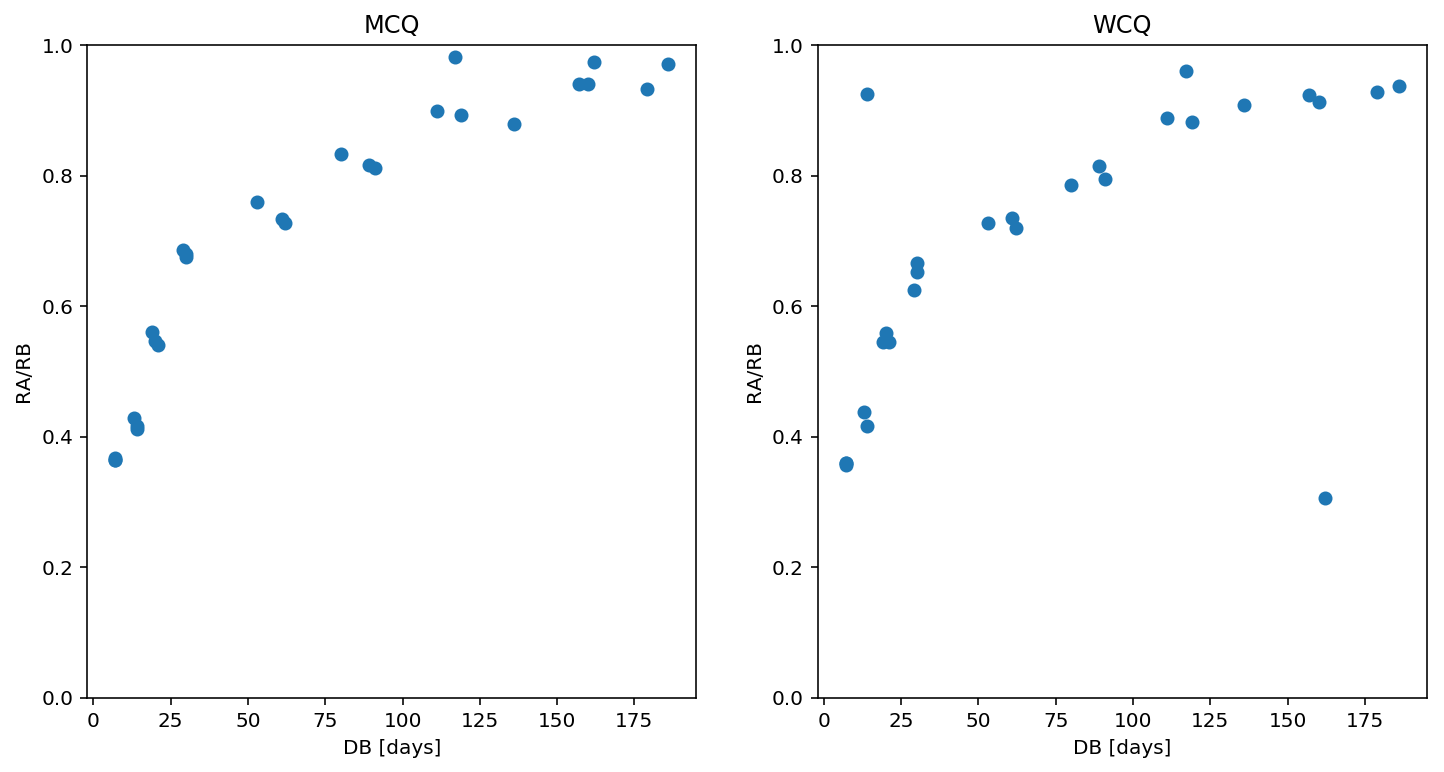

In [3]:
mcq_questions = pd.read_csv('mcq_questions.csv')
wcq_questions = pd.read_csv('wcq_questions.csv')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(x=mcq_questions['DB'], y=mcq_questions['RA']/mcq_questions['RB'])
ax[0].set(xlabel='DB [days]', ylabel='RA/RB', title='MCQ', ylim=[0,1])

ax[1].scatter(x=wcq_questions['DB'], y=wcq_questions['RA']/wcq_questions['RB'])
ax[1].set(xlabel='DB [days]', ylabel='RA/RB', title='WCQ', ylim=[0,1]);

*NOTE: There were 2 transcriptional errors when constructing the WCQ. This resulted in the ratio between the immediate and the delayed rewards deviating from what you would see in the corresponding questions in the MCQ. These errors are in questions 9 and 10 of the WCQ as entered on the online questionnaire. This does not pose a problem in terms of scoring the discount rates, but it should be kept in mind that there are these 2 unintended deviations in our WCQ questions.*

Define pre-processing functions.

In [4]:
def split_apply_combine(df, func, args):
    '''Ben's useful split-apply-combine utility function.
    We split by row, iterate over them applying the function, then combine into a
    single dataframe.'''
    output = []
    for i in range(df.shape[0]):
        # split by row
        row = df.iloc[i,:]
        # apply function
        output.append(func(row, i, args))
        
    # combine
    output = pd.concat(output, ignore_index=True)
    return output


def process_participant(row, i, questions):
    '''Take in a row of raw data and convert it to one row = one trial'''
    
    # combine responses with the questions
    df = copy.copy(questions)
    df['R'] = row.iloc[1:].values
    
    # add participant number column
    df['id'] = pd.Series(i, index=df.index)
    df['participant_number'] = pd.Series(row['participant_number'], index=df.index)
    
    return df

Process the MCQ data

## Extract just the MCQ/WCQ information into csv files

In [5]:
data = pd.read_csv('../all_cleaned.csv')


# extract just the MCQ relevant columns
subset = data.filter(regex='participant_number|MCQ')
# save
subset.to_csv('mcq_raw_data.csv', index=False)

# for the WCQ we first need to filter for rows where the IWL column equals 'yes'
data = data[data['IWL']=='yes']
# extract just the WCQ relevant columns
subset = data.filter(regex='participant_number|WCQ')

# save
subset.to_csv('wcq_raw_data.csv', index=False)

## Transform this raw data into a form we can score in order to obtain log discount rates

First with the MCQ data

In [6]:
fname = 'mcq_raw_data.csv'
data = pd.read_csv(fname)
data.head()

,participant_number,MCQ1,MCQ2,MCQ3,MCQ4,MCQ5,MCQ6,MCQ7,MCQ8,MCQ9,...,MCQ18,MCQ19,MCQ20,MCQ21,MCQ22,MCQ23,MCQ24,MCQ25,MCQ26,MCQ27
0,412729-412720-42950469,0,0,0,1,1,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
1,412729-412720-42978122,0,1,1,1,1,0,1,1,0,...,1,1,0,1,1,1,0,1,0,1
2,412729-412720-42947943,0,1,1,1,1,0,1,1,0,...,1,1,0,1,1,1,0,1,0,1
3,412729-412720-43152676,0,1,1,1,1,0,1,1,0,...,1,1,0,1,0,1,0,1,0,1
4,412729-412720-42950409,0,1,1,1,1,0,1,1,0,...,1,1,0,1,1,1,1,1,0,1


In [7]:
mcq_processed_data = split_apply_combine(data, process_participant, mcq_questions)
mcq_processed_data.to_csv('mcq_processed.csv', index=False)
mcq_processed_data.head()

,RA,DA,RB,DB,R,id,participant_number
0,54,0,55,117,0,0,412729-412720-42950469
1,55,0,75,61,0,0,412729-412720-42950469
2,19,0,25,53,0,0,412729-412720-42950469
3,31,0,85,7,1,0,412729-412720-42950469
4,14,0,25,19,1,0,412729-412720-42950469


Now the WCQ data

In [8]:
data = pd.read_csv('wcq_raw_data.csv')
data.head()

wcq_processed_data = split_apply_combine(data, process_participant, wcq_questions)
wcq_processed_data.to_csv('wcq_processed.csv', index=False)
wcq_processed_data.head()

,RA,DA,RB,DB,R,id,participant_number
0,2.4,0,2.5,117,0,0,412729-412720-42950469
1,2.5,0,3.4,61,0,0,412729-412720-42950469
2,0.8,0,1.1,53,0,0,412729-412720-42950469
3,1.4,0,3.9,7,1,0,412729-412720-42950469
4,0.6,0,1.1,19,1,0,412729-412720-42950469


## Scoring of data
We use the collated response data in `mcq_processed.csv` and `wcq_processed.csv` to score both tasks. We end up with $\ln(k_{money})$ and $\ln(k_{weight})$ scores for the MCQ and WCQ, respectively.

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import pymc3 as pm
# import math
# import numpy.matlib
# from sklearn.metrics import log_loss, roc_auc_score

from inference import build_model
from summary_table import build_final_table
from plotting import participant_plot
from utils import get_n_participants

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [10]:
# Initialize random number generator
SEED = 12345
np.random.seed(SEED)

# Define sampler options (for MCMC, not Variational Inference)
sample_options = {'tune': 6000, 'draws': 8000,
                  'chains': 4, 'cores': 4,
                  'nuts_kwargs': {'target_accept': 0.95},
                  'random_seed': SEED}

In [11]:
def run_scoring_procedure(task='mcq', plot=True, method='MCMC'):
    
    # DATA IMPORT / PROCESSING
    data = pd.read_csv(task+'_processed.csv', index_col=False)
    
    # CONSTRUCT PyMC3 MODEL
    model = build_model(data)
    
    if method == 'VI':
        with model:
            advi_fit = pm.fit(method=pm.ADVI(), n=50_000)

            advi_elbo = pd.DataFrame({'log-ELBO': -np.log(advi_fit.hist),
                                      'n': np.arange(advi_fit.hist.shape[0])})
            plt.plot(advi_elbo['n'], advi_elbo['log-ELBO'])
            trace = advi_fit.sample(10_000)
            
    elif method == 'MCMC':
        with model:
            trace = pm.sample(**sample_options)
    
    parameter_estimates = build_final_table(trace, data)
    
    # add pre-fixes to the column headers to mark if they correspond to MCQ or WCQ
    prefix = task+'_'

    parameter_estimates = parameter_estimates.rename(index=str, 
                                                     columns={"AUC_goodness_of_fit": prefix+"AUC_goodness_of_fit",
                                                              "percent_predicted": prefix+"percent_predicted", 
                                                              "log_loss": prefix+"log_loss"})
    
    if task is 'mcq':
        parameter_estimates = parameter_estimates.rename(index=str, columns={"logk": "ln_kmoney"})
    elif task is 'wcq':
        parameter_estimates = parameter_estimates.rename(index=str, columns={"logk": "ln_kweight"})
    
    print('Exporting results to file')
    parameter_estimates.to_csv(task+'_results.csv', index=False)
    
    if plot:
        print('Plotting and saving figures...')
        for id in range(get_n_participants(data)):
            # print(f'{id+1} of {n_participants}')
            participant_plot(id, trace, data, legend=False, n_samples_to_plot=0)

            savename = f'plots/{task}_id{id}.pdf'
            plt.savefig(savename, bbox_inches='tight')

            # Close the figure to avoid heavy plotting inside the notebook
            plt.close(plt.gcf())
            
    return parameter_estimates, trace

Run scoring for MCQ

In [13]:
mcq_results, mcq_trace = run_scoring_procedure(task='mcq', plot=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logk, sigma_logk, mu_logk]
Sampling 4 chains: 100%|██████████| 56000/56000 [14:25<00:00, 64.73draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Calculating derived measures and building summary table
Exporting results to file
Plotting and saving figures...


In [14]:
mcq_results.head()

,id,participant_number,logk_money,mcq_percent_predicted
0,0,412729-412720-42950469,-3.702400,1.000000
1,1,412729-412720-42978122,-6.826825,0.962963
2,2,412729-412720-42947943,-6.826818,0.962963
3,3,412729-412720-43152676,-5.241802,0.962963
4,4,412729-412720-42950409,-6.774210,0.962963


Run scoring for WCQ

In [15]:
wcq_results, wcq_trace = run_scoring_procedure(task='wcq', plot=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logk, sigma_logk, mu_logk]
Sampling 4 chains: 100%|██████████| 56000/56000 [03:03<00:00, 305.20draws/s]


Calculating derived measures and building summary table
Exporting results to file
Plotting and saving figures...


In [16]:
wcq_results.head()

,id,participant_number,logk_weight,wcq_percent_predicted
0,0,412729-412720-42950469,-2.754500,0.962963
1,1,412729-412720-42978122,-2.760381,0.888889
2,2,412729-412720-42947943,-0.726473,1.000000
3,3,412729-412720-43152676,-5.402992,0.962963
4,4,412729-412720-42950409,-5.130899,0.962963


## Add MCQ and WCQ related columns to overall dataset
We will take the original raw data, append the MCQ and WCQ information and export as a new final dataset ready for analysis. Combine so that `participant_number`'s line up.

In [28]:
initial_dataset = pd.read_csv('../all_cleaned.csv')

# combine on the participant_number variable
a = initial_dataset.set_index('participant_number')
m = mcq_results.set_index('participant_number')
w = wcq_results.set_index('participant_number')

# remove the 'id' columns
m = m.drop(['id'], axis=1)
w = w.drop(['id'], axis=1)

# combine
done = pd.concat([a, m, w], axis=1, sort=False)

# drop the raw response columns
done.drop(list(done.filter(regex = 'MCQ')), axis = 1, inplace = True)
done.drop(list(done.filter(regex = 'WCQ')), axis = 1, inplace = True)

Filter out participants with `percent_predicted` below threshold value

In [29]:
percent_predicted_threshold = 0.70

In [30]:
keep = done.mcq_percent_predicted >= percent_predicted_threshold
print(done.shape)
print(f'REMOVING {sum(keep == False)} PARTICIPANTS, BASED ON PERCENT PREDICTED (MCQ) BELOW THRESHOLD')
done = done[keep == True]
print(done.shape)

(385, 19)
REMOVING 1 PARTICIPANTS, BASED ON PERCENT PREDICTED (MCQ) BELOW THRESHOLD
(384, 19)


In [31]:
keep = np.logical_or(done.wcq_percent_predicted >= percent_predicted_threshold,
                     done.wcq_percent_predicted.isna()==True)
print(done.shape)
print(f'REMOVING {sum(keep == False)} PARTICIPANTS, BASED ON PERCENT PREDICTED (WCQ) BELOW THRESHOLD')
done = done[keep]
print(done.shape)

(384, 19)
REMOVING 3 PARTICIPANTS, BASED ON PERCENT PREDICTED (WCQ) BELOW THRESHOLD
(381, 19)


## Create discount rate ratio column

In [51]:
done['ln_kratio'] = done.logk_weight / done.logk_money

## Export final dataset

In [52]:
done.to_csv('../all_cleaned_scored.csv', index=True)

Calculate median percent responses predicted.

In [47]:
np.median(done.mcq_percent_predicted)

0.9259259259259259

In [48]:
wcq_percent_predicted = done.wcq_percent_predicted.values
wcq_percent_predicted = wcq_percent_predicted[~np.isnan(wcq_percent_predicted)]
np.median(wcq_percent_predicted)

0.8888888888888888